
🔢 Model uses 68 variables and 52 constraints

📝 Bed Summary:


/var/folders/8l/cxmhybfd0fj87qlcmz7b82nh0000gn/T/ipykernel_45285/2171165626.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(species_list))


,TotalPlants,UsedArea,Capacity,PctUsed
Bed,,,,
A,22,4608.0,4608,100.000000
B,25,4608.0,4608,100.000000
C,134,4603.0,4608,99.891493
D,32,4608.0,4608,100.000000



🌿 Overall Plant Counts:


,A,B,C,D,Total
"Onion, Yellow",0,0,104,16,120
"Onion, Bunching",0,0,19,0,19
Bell Pepper,1,12,0,3,16
"Tomato, Cherry",3,1,0,12,16
Jalapeno,12,0,0,0,12
Spearmint,5,1,2,0,8
"Tomato, Beefsteak",0,6,0,0,6
"Lavendar, English",1,1,1,1,4
"Lettuce, Romaine",0,0,4,0,4
"Parsley, Italian",0,4,0,0,4



🔍 Bed A Breakdown:


,Count,AreaUsed,PctOfBed
Plant,,,
Jalapeno,12,1728.0,37.50000
Spearmint,5,1620.0,35.15625
"Tomato, Cherry",3,972.0,21.09375
Bell Pepper,1,144.0,3.12500
"Lavendar, English",1,144.0,3.12500


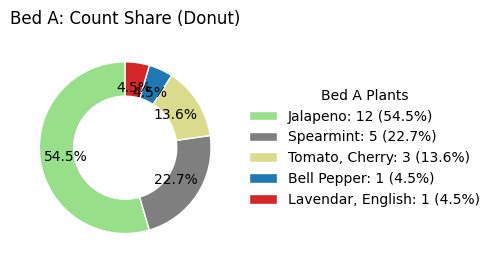

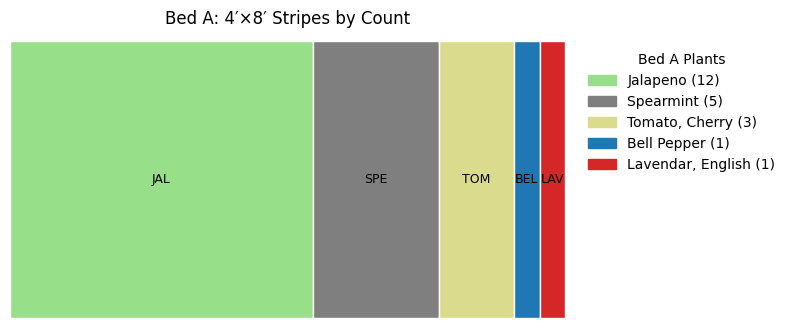

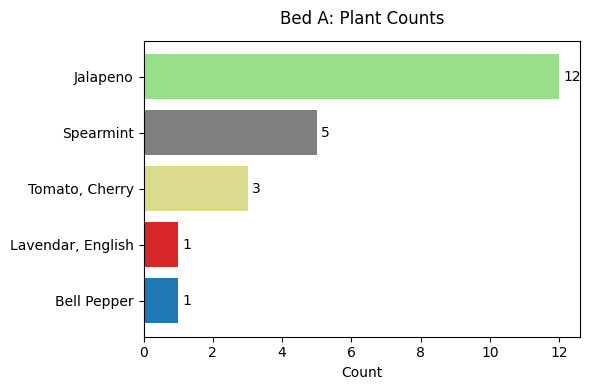


🔍 Bed B Breakdown:


,Count,AreaUsed,PctOfBed
Plant,,,
Bell Pepper,12,1728.0,37.50000
"Tomato, Beefsteak",6,1944.0,42.18750
"Parsley, Italian",4,144.0,3.12500
"Lavendar, English",1,144.0,3.12500
Spearmint,1,324.0,7.03125
"Tomato, Cherry",1,324.0,7.03125


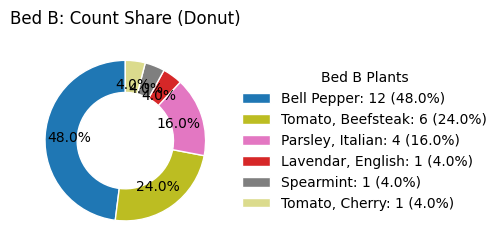

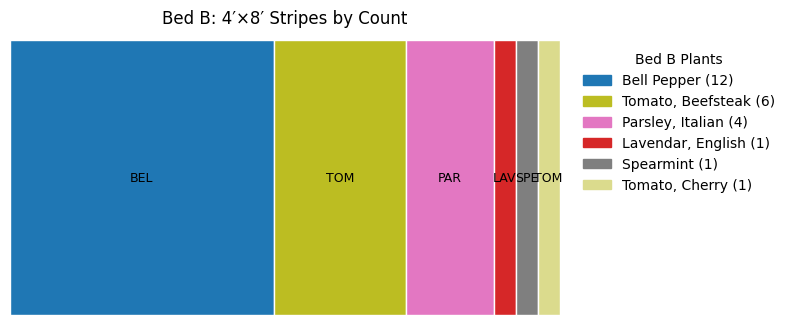

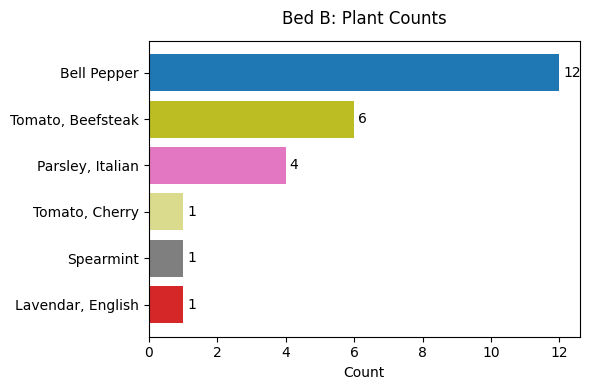


🔍 Bed C Breakdown:


,Count,AreaUsed,PctOfBed
Plant,,,
"Onion, Yellow",104,936.0,20.312500
"Onion, Bunching",19,171.0,3.710938
"Lettuce, Romaine",4,400.0,8.680556
Zucchini,4,2304.0,50.000000
Spearmint,2,648.0,14.062500
"Lavendar, English",1,144.0,3.125000


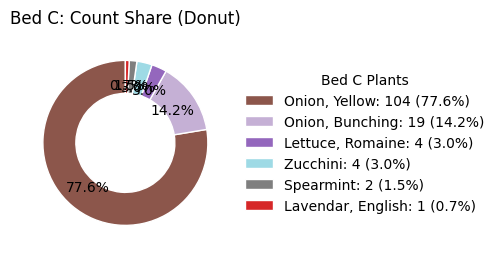

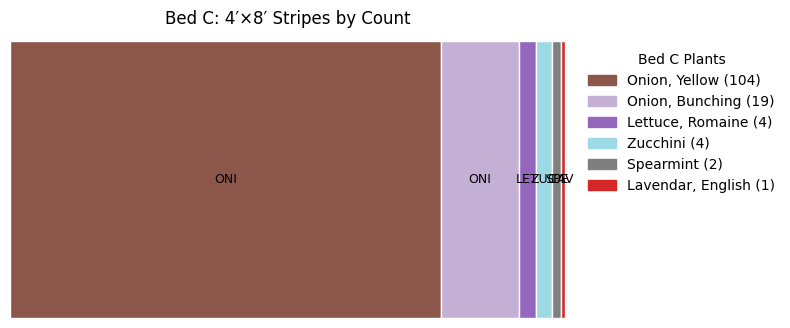

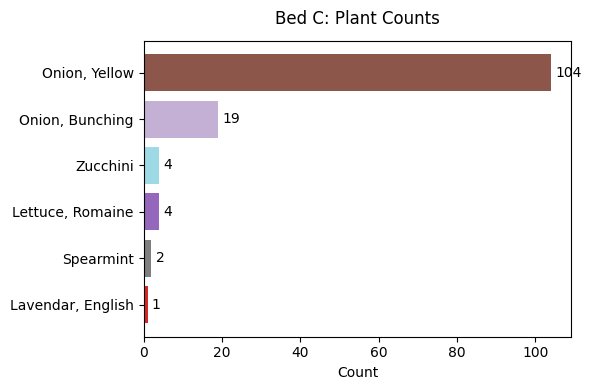


🔍 Bed D Breakdown:


,Count,AreaUsed,PctOfBed
Plant,,,
"Onion, Yellow",16,144.0,3.125
"Tomato, Cherry",12,3888.0,84.375
Bell Pepper,3,432.0,9.375
"Lavendar, English",1,144.0,3.125


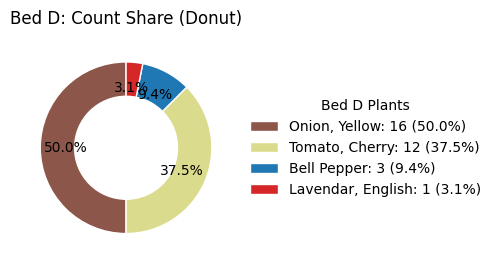

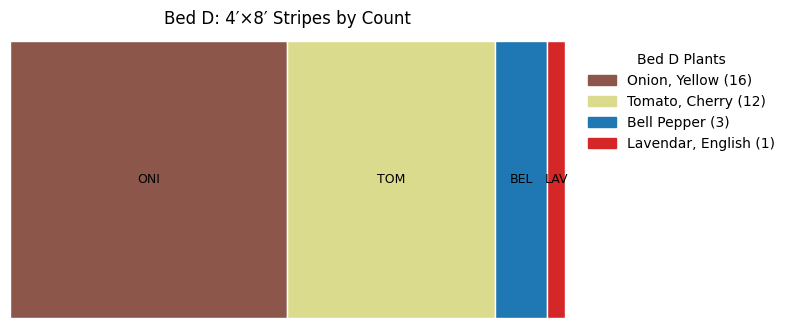

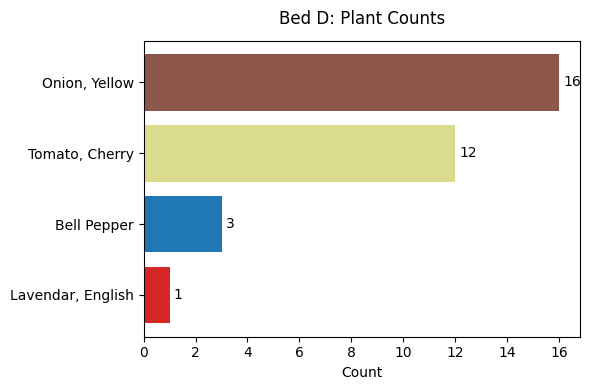

In [1]:
# pip install docplex pandas matplotlib
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from docplex.mp.model import Model

# ── 1) Parse spacing into (min, max)
def parse_spacing(txt):
    nums = list(map(float, re.findall(r'\d+\.?\d*', str(txt))))
    if not nums:
        raise ValueError(f"No numbers in '{txt}'")
    return min(nums), max(nums)

# ── 2) Load & normalize data
def load_data(path="garden_capstone_data.xlsx"):
    qty    = pd.read_excel(path, sheet_name="Quantity Requirements")
    layout = pd.read_excel(path, sheet_name="Garden Layout")
    qty = qty.rename(columns={
        "Revised Names":"Plant",
        "Plant in 2025":"PlantThisYear",
        "Min Required":"MinReq",
        "Max Required":"MaxReq",
        "Exact Required":"ExactReq",
        "One per bed?":"OnePerBed",
        "All in one bed?":"AllInOneBed",
        "Spacing Between Plants":"Spacing"
    })
    mins, maxs = zip(*(qty["Spacing"].map(parse_spacing)))
    qty["MinSp"], qty["MaxSp"] = mins, maxs

    colmap = {}
    for c in layout.columns:
        lc = c.strip().lower()
        if "garden beds" in lc: colmap[c] = "Bed"
        elif "length"      in lc: colmap[c] = "Length_ft"
        elif "width"       in lc: colmap[c] = "Width_ft"
    layout = layout.rename(columns=colmap)[["Bed","Length_ft","Width_ft"]]
    layout["BedArea"] = layout["Length_ft"] * layout["Width_ft"] * 144
    return qty, layout

# ── 3) Build optimization model
def build_model(qty, layout, plant_area):
    mdl    = Model("Garden")
    plants = qty["Plant"].tolist()
    beds   = layout["Bed"].tolist()
    x = mdl.integer_var_dict(((p,b) for p in plants for b in beds), lb=0, name="x")

    # a) only plant if “Yes”
    for _,r in qty.iterrows():
        p = r["Plant"]
        s = mdl.sum(x[p,b] for b in beds)
        if str(r["PlantThisYear"]).strip().lower()=="yes":
            mdl.add_constraint(s >= 1, f"plant_{p}")
        else:
            mdl.add_constraint(s == 0, f"noplant_{p}")

    # b) bed capacity
    for b in beds:
        cap = layout.loc[layout["Bed"]==b,"BedArea"].iat[0]
        mdl.add_constraint(
            mdl.sum(x[p,b]*plant_area[p] for p in plants) <= cap,
            f"cap_{b}"
        )

    # c/d/e) min/max/exact requirements
    for _,r in qty.iterrows():
        p   = r["Plant"]
        tot = mdl.sum(x[p,b] for b in beds)
        if pd.notna(r["ExactReq"]):
            mdl.add_constraint(tot == int(r["ExactReq"]), f"exact_{p}")
        else:
            if pd.notna(r["MinReq"]):
                mdl.add_constraint(tot >= int(r["MinReq"]), f"min_{p}")
            if pd.notna(r["MaxReq"]):
                mdl.add_constraint(tot <= int(r["MaxReq"]), f"max_{p}")

    # f) one-per-bed
    for _,r in qty.iterrows():
        if str(r["OnePerBed"]).strip().lower().startswith("y"):
            p = r["Plant"]
            for b in beds:
                mdl.add_constraint(x[p,b] == 1, f"one_{p}_{b}")

    # g) all-in-one-bed
    bigM = int(qty["MaxReq"].max(skipna=True) or len(beds)*5)
    for _,r in qty.iterrows():
        if str(r["AllInOneBed"]).strip().lower().startswith("y"):
            p = r["Plant"]
            z = mdl.binary_var_dict(beds, name=f"z_{p}")
            for b in beds:
                mdl.add_constraint(x[p,b] <= bigM*z[b], f"group_{p}_{b}")
            mdl.add_constraint(mdl.sum(z[b] for b in beds) == 1, f"onebed_{p}")

    # h) all beds used
    for b in beds:
        mdl.add_constraint(mdl.sum(x[p,b] for p in plants) >= 1, f"usebed_{b}")

    # Objective: maximize total planted area
    total = mdl.sum(x[p,b]*plant_area[p] for p in plants for b in beds)
    mdl.maximize(total)
    return mdl, x

# ── 4) Iteratively scale spacing
def find_max_spacing(qty, layout, step_ratio=0.1):
    min_sp = qty["MinSp"].values
    max_sp = qty["MaxSp"].values
    limit  = np.min(max_sp / min_sp)
    best_r, best_sol = 1.0, None
    r = 1.0
    while r <= limit + 1e-6:
        plant_area = {p:(qty.loc[qty["Plant"]==p,"MinSp"].iat[0]*r)**2
                      for p in qty["Plant"]}
        mdl, x = build_model(qty, layout, plant_area)
        sol = mdl.solve(log_output=False)
        if not sol:
            break
        best_r, best_sol = r, (mdl, x)
        r += step_ratio
    return best_r, best_sol

# ── Helper: create consistent distinct colors
def make_color_map(species_list):
    cmap = plt.cm.get_cmap('tab20', len(species_list))
    return {p: cmap(i) for i,p in enumerate(species_list)}

# ── 5) Reporting & Visualization
def report_solution(qty, layout, mdl, x, ratio):
    plants = qty["Plant"].tolist()
    beds   = layout["Bed"].tolist()
    # per-plant footprint
    area_map = {p:(qty.loc[qty["Plant"]==p,"MinSp"].iat[0]*ratio)**2 for p in plants}
    # global consistent color map
    color_map = make_color_map(plants)

    # Model statistics
    n_vars = len(list(mdl.iter_variables()))
    n_cons = len(list(mdl.iter_constraints()))
    print(f"\n🔢 Model uses {n_vars} variables and {n_cons} constraints")

    # Summary table
    summary = []
    for b in beds:
        total_plants = sum(int(x[p,b].solution_value) for p in plants)
        used_area    = sum(int(x[p,b].solution_value)*area_map[p] for p in plants)
        cap          = layout.loc[layout["Bed"]==b,"BedArea"].iat[0]
        pct_used     = used_area / cap * 100
        summary.append({
            "Bed": b,
            "TotalPlants": total_plants,
            "UsedArea": used_area,
            "Capacity": cap,
            "PctUsed": pct_used
        })
    df_summary = pd.DataFrame(summary).set_index("Bed")
    print("\n📝 Bed Summary:")
    display(df_summary)
    df_summary.to_excel("bed_summary_table.xlsx")

    # Detailed counts table
    df_counts = pd.DataFrame(
        [{b:int(x[p,b].solution_value) for b in beds} for p in plants],
        index=plants
    )
    df_counts["Total"] = df_counts.sum(axis=1)
    print("\n🌿 Overall Plant Counts:")
    display(df_counts.sort_values("Total", ascending=False))
    df_counts.to_excel("overall_plant_counts.xlsx")

    # Per-bed breakdown & plots
    for b in beds:
        # breakdown DataFrame
        rows = []
        for p in plants:
            cnt = int(x[p,b].solution_value)
            if cnt>0:
                area_used = cnt * area_map[p]
                pct_bed   = area_used / layout.loc[layout["Bed"]==b,"BedArea"].iat[0] * 100
                rows.append({"Plant":p,"Count":cnt,"AreaUsed":area_used,"PctOfBed":pct_bed})
        if not rows:
            continue
        df = pd.DataFrame(rows).set_index("Plant").sort_values("Count", ascending=False)
        print(f"\n🔍 Bed {b} Breakdown:")
        display(df)
        df.to_excel(f"bed_{b}_breakdown.xlsx")

        # Donut chart
        ser = df["Count"]
        fig, ax = plt.subplots(figsize=(5,5))
        wedges, _, _ = ax.pie(
            ser.values,
            colors=[color_map[p] for p in ser.index],
            startangle=90,
            autopct="%1.1f%%",
            pctdistance=0.7,
            wedgeprops=dict(width=0.4, edgecolor="white")
        )
        centre = plt.Circle((0,0),0.4,fc='white'); ax.add_artist(centre)
        legend_lbls = [f"{p}: {ser[p]} ({ser[p]/ser.sum()*100:.1f}%)" for p in ser.index]
        ax.legend(wedges, legend_lbls,
                  title=f"Bed {b} Plants", bbox_to_anchor=(1.02,0.5),
                  loc="center left", frameon=False)
        ax.set_title(f"Bed {b}: Count Share (Donut)", pad=12)
        plt.tight_layout()
        plt.savefig(f"bed_{b}_count_share_donut.png", dpi=200, bbox_inches="tight")
        plt.show()

        # Stripes by count (4'×8')
        L = layout.loc[layout["Bed"]==b,"Length_ft"].iat[0] * 12
        H = layout.loc[layout["Bed"]==b,"Width_ft"].iat[0]  * 12
        total = ser.sum()
        species = ser.sort_values(ascending=False).index.tolist()
        fig, ax = plt.subplots(figsize=(8,4))
        ax.set_xlim(0,L); ax.set_ylim(0,H); ax.set_aspect("equal"); ax.axis("off")
        ax.set_title(f"Bed {b}: 4′×8′ Stripes by Count", pad=12)
        x0 = 0
        for p in species:
            w = ser[p]/total * L
            ax.add_patch(Rectangle((x0,0), w, H,
                                   facecolor=color_map[p],
                                   edgecolor="white", linewidth=1))
            ax.text(x0 + w/2, H/2, p[:3].upper(),
                    ha="center", va="center", fontsize=9, color="black")
            x0 += w
        handles = [Rectangle((0,0),1,1,color=color_map[p]) for p in species]
        labels  = [f"{p} ({ser[p]})" for p in species]
        ax.legend(handles, labels,
                  title=f"Bed {b} Plants", bbox_to_anchor=(1.02,1),
                  loc="upper left", frameon=False)
        plt.tight_layout()
        plt.savefig(f"bed_{b}_stripes_by_count.png", dpi=200, bbox_inches="tight")
        plt.show()

        # Horizontal bar chart of counts
        fig, ax = plt.subplots(figsize=(6, max(4,len(species)*0.4)))
        ser_sorted = ser.sort_values(ascending=True)
        ax.barh(ser_sorted.index, ser_sorted.values,
                color=[color_map[p] for p in ser_sorted.index])
        for i,(plant, cnt) in enumerate(ser_sorted.items()):
            ax.text(cnt + max(ser_sorted.values)*0.01, i, str(cnt), va="center")
        ax.set_xlabel("Count")
        ax.set_title(f"Bed {b}: Plant Counts", pad=12)
        plt.tight_layout()
        plt.savefig(f"bed_{b}_counts_barh.png", dpi=200, bbox_inches="tight")
        plt.show()

# ── 6) Main
if __name__=="__main__":
    qty, layout = load_data()
    ratio, sol = find_max_spacing(qty, layout)
    if sol is None:
        print("❌ Infeasible even at minimum spacing!")
    else:
        mdl, x = sol
        report_solution(qty, layout, mdl, x, ratio)


/var/folders/8l/cxmhybfd0fj87qlcmz7b82nh0000gn/T/ipykernel_45285/1670566915.py:15: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  plt.savefig("model_complexity.png", dpi=200, bbox_inches="tight")
/opt/anaconda3/envs/python310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


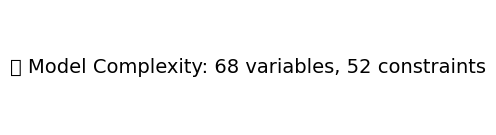

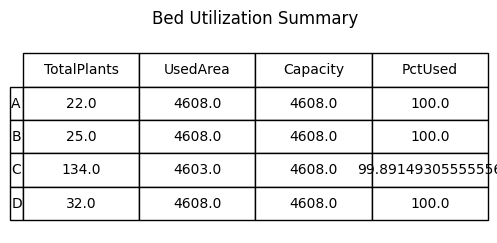

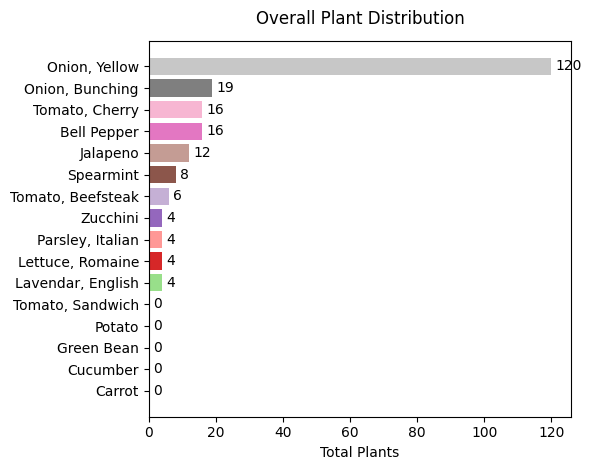

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load summary tables
df_summary = pd.read_excel("bed_summary_table.xlsx", index_col=0)
df_counts  = pd.read_excel("overall_plant_counts.xlsx", index_col=0)

# 1. Model Complexity
n_vars, n_cons = 68, 52
fig, ax = plt.subplots(figsize=(6, 1.5))
ax.axis("off")
ax.text(0.5, 0.5,
        f"🔢 Model Complexity: {n_vars} variables, {n_cons} constraints",
        ha="center", va="center", fontsize=14)
plt.savefig("model_complexity.png", dpi=200, bbox_inches="tight")
plt.show()

# 2. Bed Utilization Summary Table
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.axis("off")
tbl = ax.table(cellText=df_summary.values,
               rowLabels=df_summary.index,
               colLabels=df_summary.columns,
               cellLoc="center", loc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 2)
ax.set_title("Bed Utilization Summary", pad=12)
plt.savefig("bed_utilization_summary.png", dpi=200, bbox_inches="tight")
plt.show()

# 3. Overall Plant Distribution Bar Chart
totals = df_counts["Total"].sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6, max(4, len(totals)*0.3)))
ax.barh(totals.index, totals.values, color=plt.cm.tab20.colors[:len(totals)])
for i, (plant, cnt) in enumerate(totals.items()):
    ax.text(cnt + max(totals.values)*0.01, i, str(cnt), va="center")
ax.set_xlabel("Total Plants")
ax.set_title("Overall Plant Distribution", pad=12)
plt.tight_layout()
plt.savefig("overall_plant_distribution.png", dpi=200, bbox_inches="tight")
plt.show()
